# Décomposition : tendance

**Objectif**
- modéliser la tendance avec différents modèles
- soustraire la tendance
- comparer les modèles

**Modèles choisis**
- Régression linéaire
- Régression polynomiale
- Moyenne mobile
- Moyenne mobile exponentielle
- B-Splines

**Critères d'évaluation**
- AIC
- MSE
- graphiquement _(la courbe ne doit pas faire "n'importe quoi")_

## Imports et lecture des données

### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf

from src.functions.detrend import (
    BSplinesDetrend,
    ExponentialMADetrend,
    LinearMADetrend,
    LinearRegressionDetrend,
    PolynomialRegressionDetrend,
)
from src.utils import init_notebook

In [ ]:
init_notebook()

In [ ]:
detrend_dict = {}

### Lecture des données

In [ ]:
data_folder = "data/raw_data"

In [ ]:
stock_name = "AAPL"

In [ ]:
df = pd.read_csv(
    f"{data_folder}/{stock_name}.csv", parse_dates=["Date"], index_col="Date"
)
print(f"{df.shape = }")

df.shape = (756, 6)


## Soustraction de la tendance

La tendance est, pour une série chronologique, sa composante première, inhérente à la nature des données. Elle peut le plus souvent se représenter par une droite, à la hausse ou à la baisse. Dans le cas des cours boursiers, le prix a une tendance généralement haussière, qui s'explique par le concept de croissance économique.

<Axes: title={'center': 'Closing price plot (daily) with trend'}, xlabel='Date'>

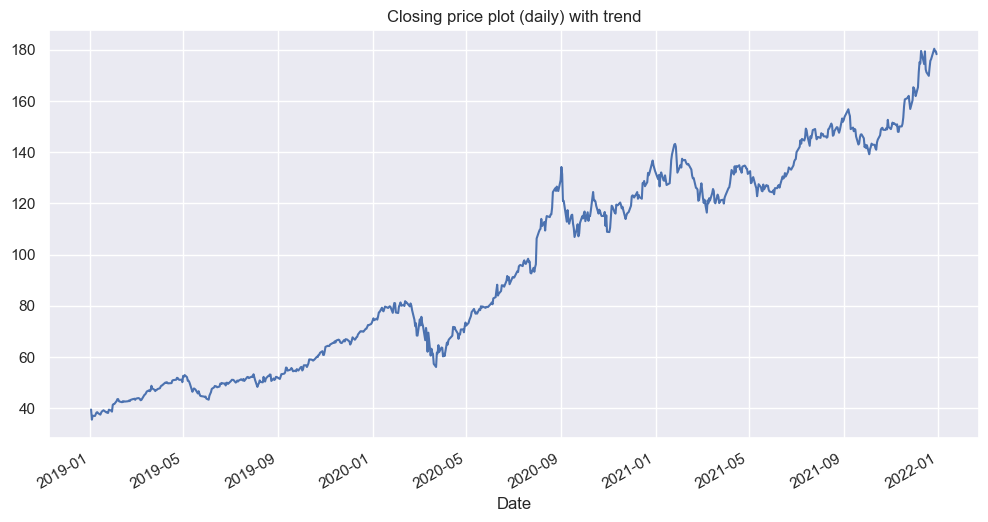

In [ ]:
df["Close"].plot(title="Closing price plot (daily) with trend", figsize=(12, 6))

### Régression linéaire

Soit le vecteur $Y = (y_1, \dots, y_N)$ des prix de clôture du cours aux temps (ici, des jours) $1, \dots, N$.  

L'objectif est de s'ajuster aux données avec un modèle de régression linéaire simple donné par l'équation :

$$Y = \beta_0 + \beta_1 * X$$

où $(\beta_0, \beta_1)$ est le vecteur des paramètres à estimer  
et $X = (1, \dots, N)$ est le vecteur _time dummy_ qui représente l'avancement linéaire du temps.  

Puis il faut soustraire au vecteur de données originales $Y$ le vecteur des prédictions $Y_{pred}$ :

$$y_{detrend_i} = y_i - y_{pred_i} \hspace{12px} \forall i \in [1;N]$$ 

In [ ]:
# Define time series to detrend
y = df["Close"]

C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\src\functions\detrend_fancy_plot.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(xticklabels)
C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\src\functions\detrend_fancy_plot.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(xticklabels)


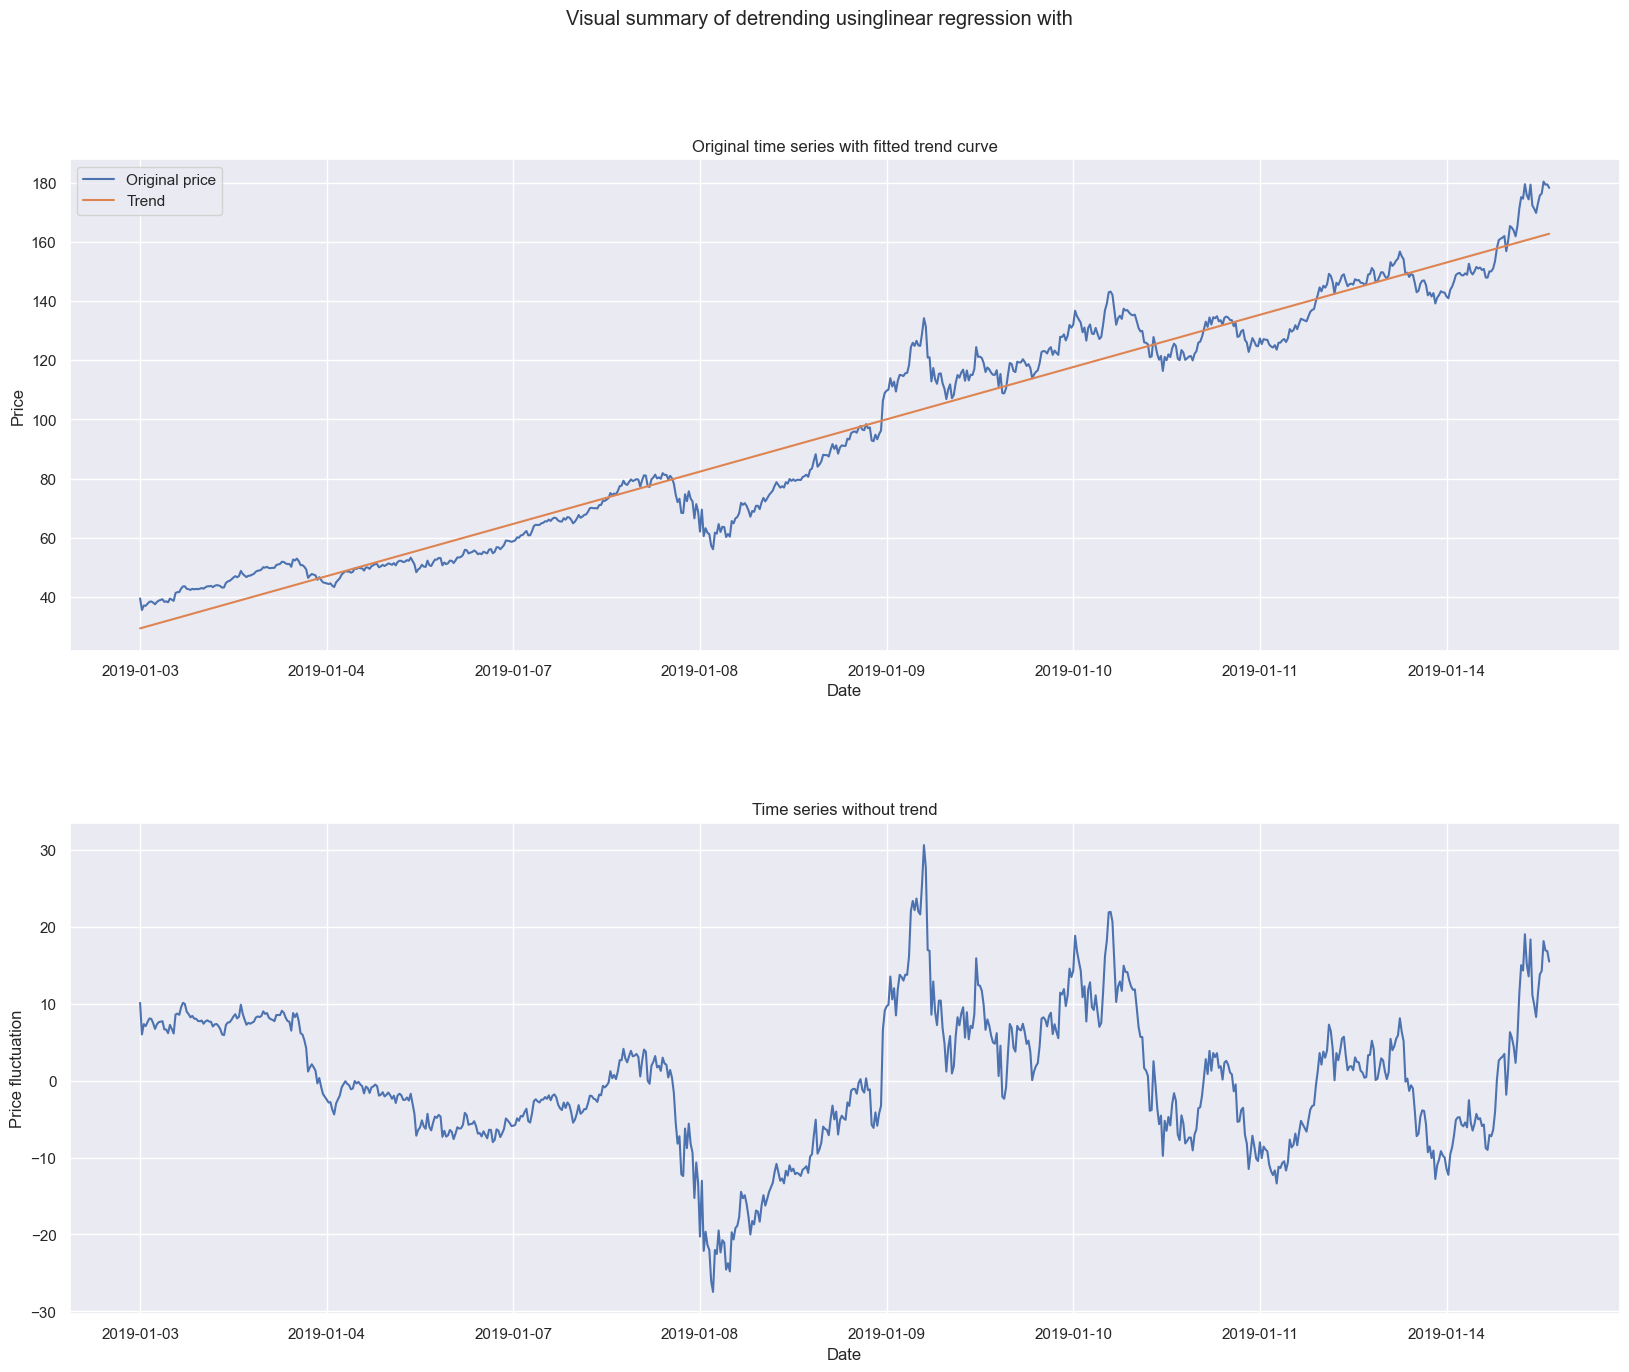

In [ ]:
# Define detrend model
detrend_model = LinearRegressionDetrend()

# Fit model to time series
y_fitted = detrend_model.fit(y)

# Substract adjusted values to original time series to get detrend data
y_detrend = detrend_model.predict(y)

# Plot the result
detrend_model.fancy_plot(xticklabels=df.index.strftime("%Y-%m-%d"))

In [ ]:
def aic(y_true, y_detrend, nb_parameters: int) -> float:
    k = nb_parameters
    n = len(y_true)

    mse = mean_squared_error(y_true, y_detrend)
    aic = n * np.log(mse) + 2 * k

    return aic

In [ ]:
aic_detrend = aic(y, y_detrend, 2)
mse_detrend = mean_squared_error(y, y_detrend)
detrend_dict["Régression linéaire"] = [aic_detrend, mse_detrend]

In [ ]:
# Input detrend close price into dataframe
df["Close_detrend"] = y_detrend

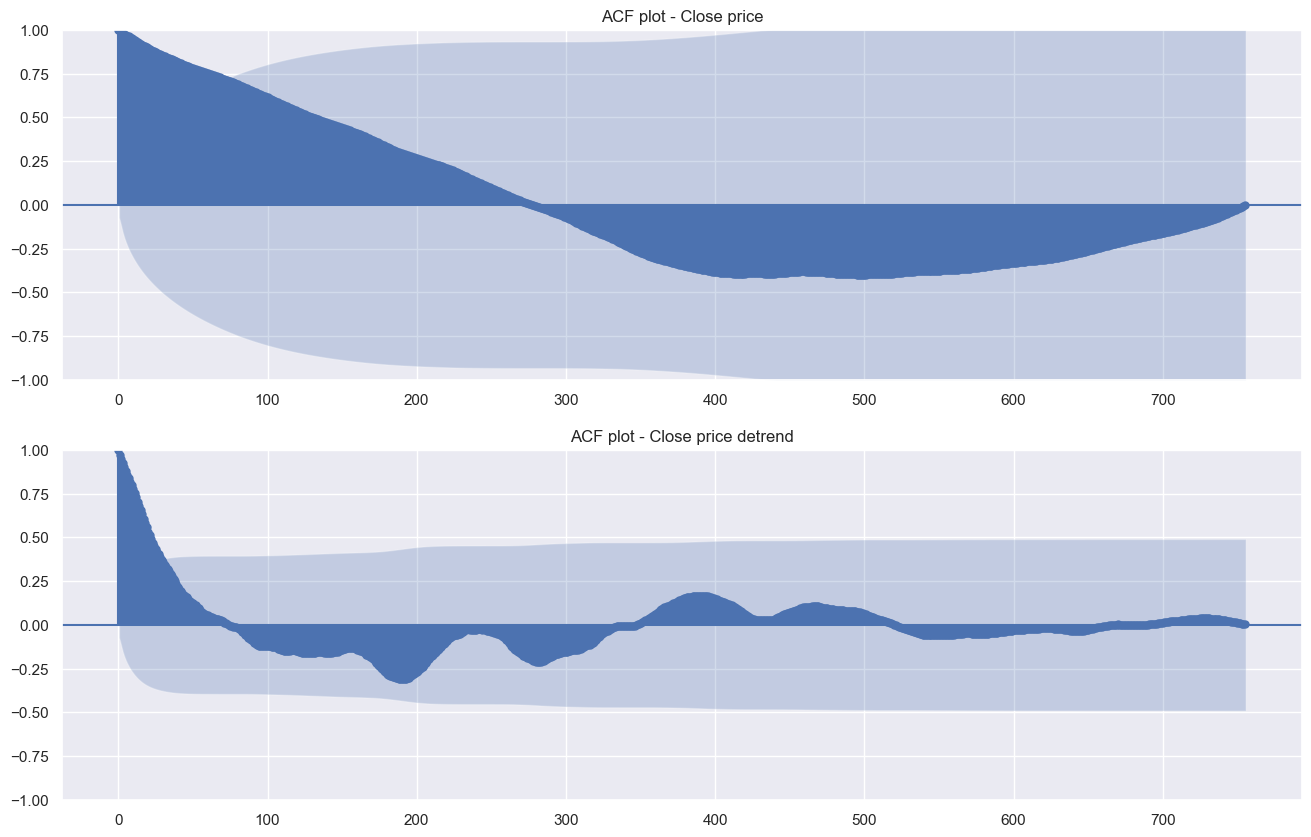

In [ ]:
# acf plot before / after

lag = len(df) - 1

_, axs = plt.subplots(2, 1, figsize=(16, 10))
_ = plot_acf(df["Close"], ax=axs[0], lags=lag, title="ACF plot - Close price")
_ = plot_acf(
    df["Close_detrend"], ax=axs[1], lags=lag, title="ACF plot - Close price detrend"
)

- Les fortes autocorrélations dans le premier graphique montrent que la série temporelle contient une <b>tendance</b>.  
- Après déconstruction de la tendance, le deuxième graphique affiche cependant encore des autocorrélations importantes <b>pour des lags petits</b>. C'est un indice de <b>saisonnalité</b> ou de <b>cyclicité</b>. 

### Régression polynomiale par morceaux

Soit $k \in N^*$.  
Pour la régression polynomiale d'ordre $k$, le même principe que la régression linéaire simple est appliqué mais avec la particularité que des <i>time dummies</i> d'ordre $1, \dots, k$ sont ajoutées comme variables explicatives au modèle.  
L'équation de régression devient :

$$ Y = \sum_{i=0}^{k} \beta_i * X_i$$

où pour tout $i \in [1;k], \hspace{6px} X_i = (1^i, 2^i, \dots, N^i)$.
 
Cette méthode permet de capter une tendance polynomiale (croissante au carré du temps par exemple).

In [ ]:
# Choose parameters of segmented polynomial regression

order = 3
n_segments = 5

C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\src\functions\detrend_fancy_plot.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(xticklabels)
C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\src\functions\detrend_fancy_plot.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(xticklabels)


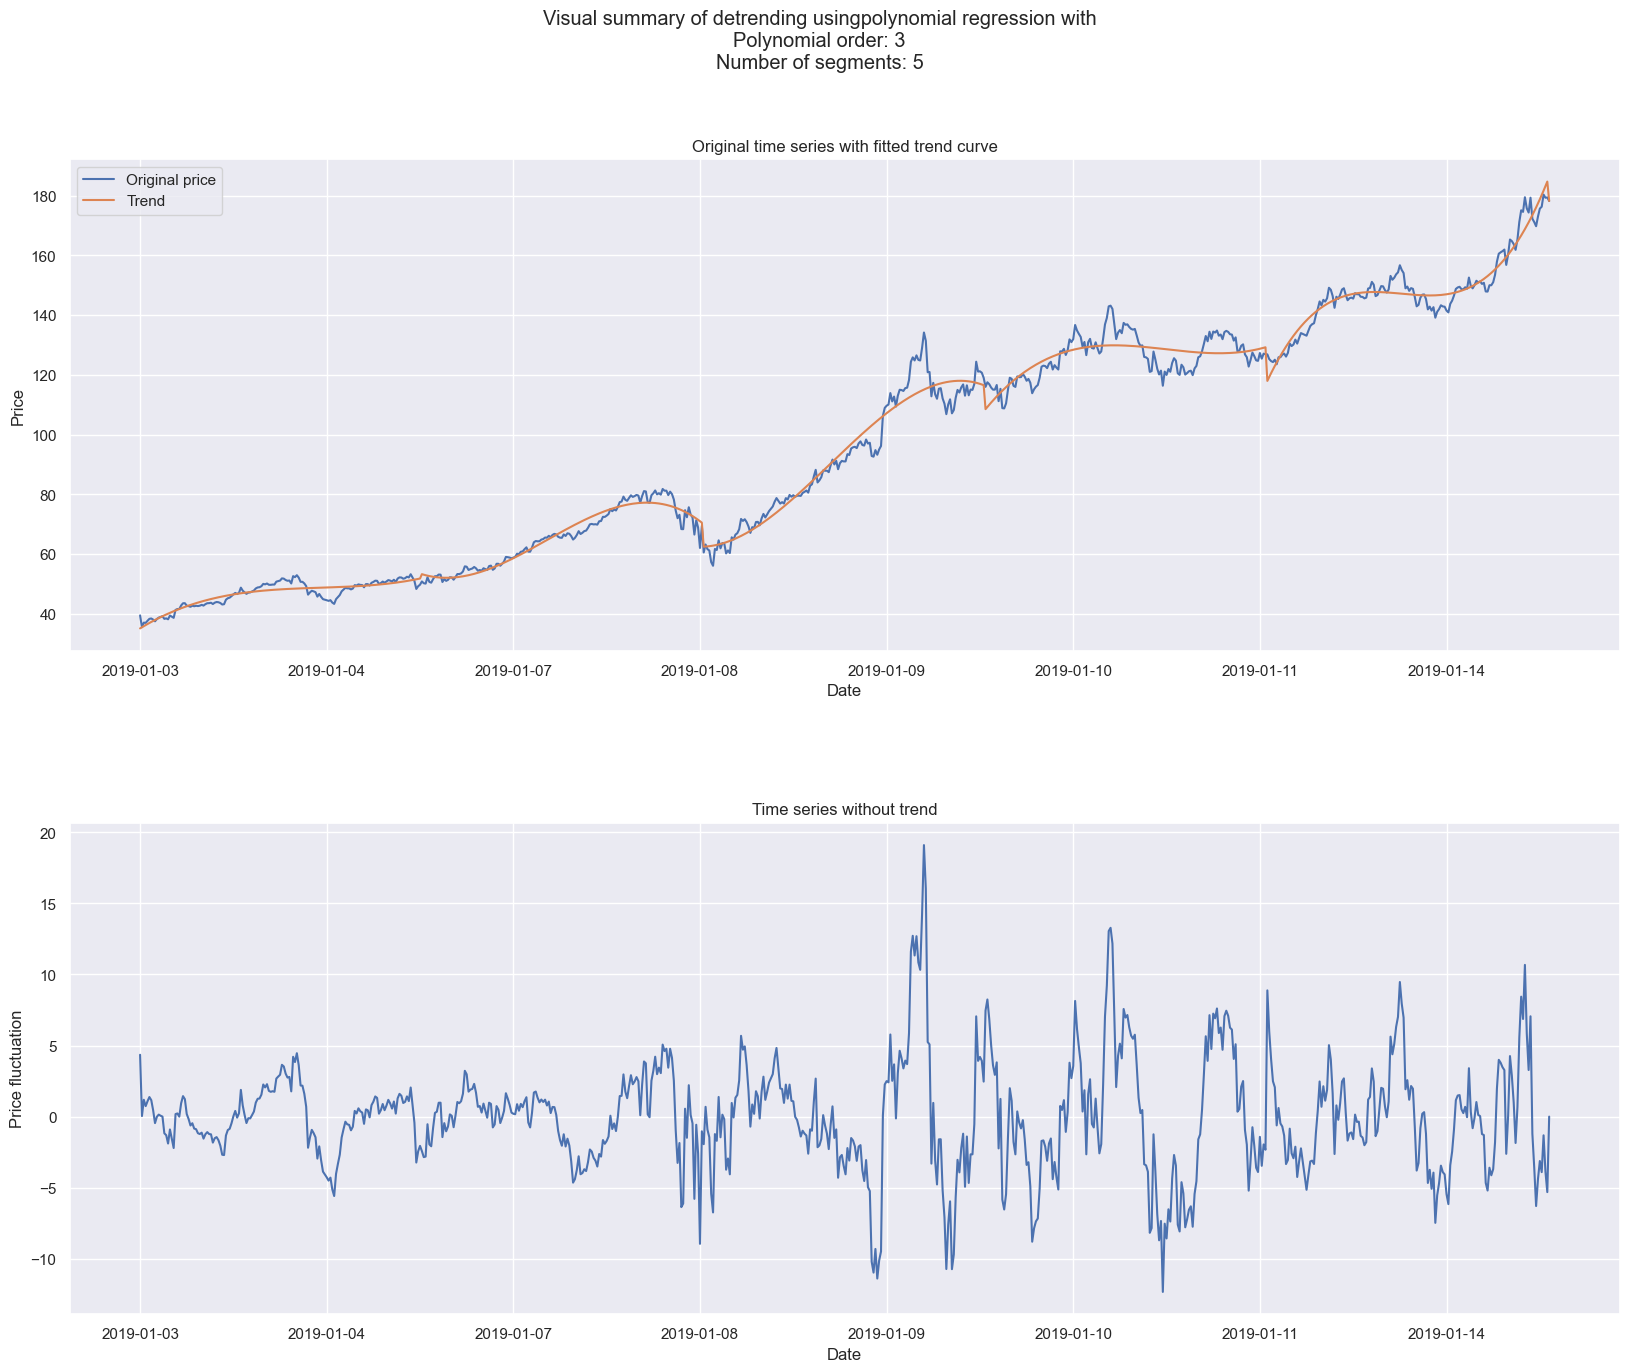

In [ ]:
# Define detrend model
detrend_model = PolynomialRegressionDetrend(order=order, n_segments=n_segments)

# Fit model to time series
y_fitted = detrend_model.fit(y)

# Substract adjusted values to original time series to get detrend data
y_detrend = detrend_model.predict(y)

# Plot the result
detrend_model.fancy_plot(xticklabels=df.index.strftime("%Y-%m-%d"))

In [ ]:
aic_detrend = aic(y, y_detrend, 2)
mse_detrend = mean_squared_error(y, y_detrend)
detrend_dict["Régression polynomiale"] = [aic_detrend, mse_detrend]

### Moyennes mobiles

#### Linéaire

On se munit de $(x_t)_{t \in \mathbb{N}}$ une série temporelle.  

Soit $(k, t) \in \mathbb{N}^* \times \llbracket k~;~+\infty \rrbracket$,  
la moyenne mobile linéaire à gauche de profondeur $k$ pour $x_t$ est :

$$ma_k(x_t) = \frac{\displaystyle \sum_{i=t-k+1}^{t}x_i}{k}$$

C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\src\functions\detrend_fancy_plot.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(xticklabels)
C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\src\functions\detrend_fancy_plot.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(xticklabels)


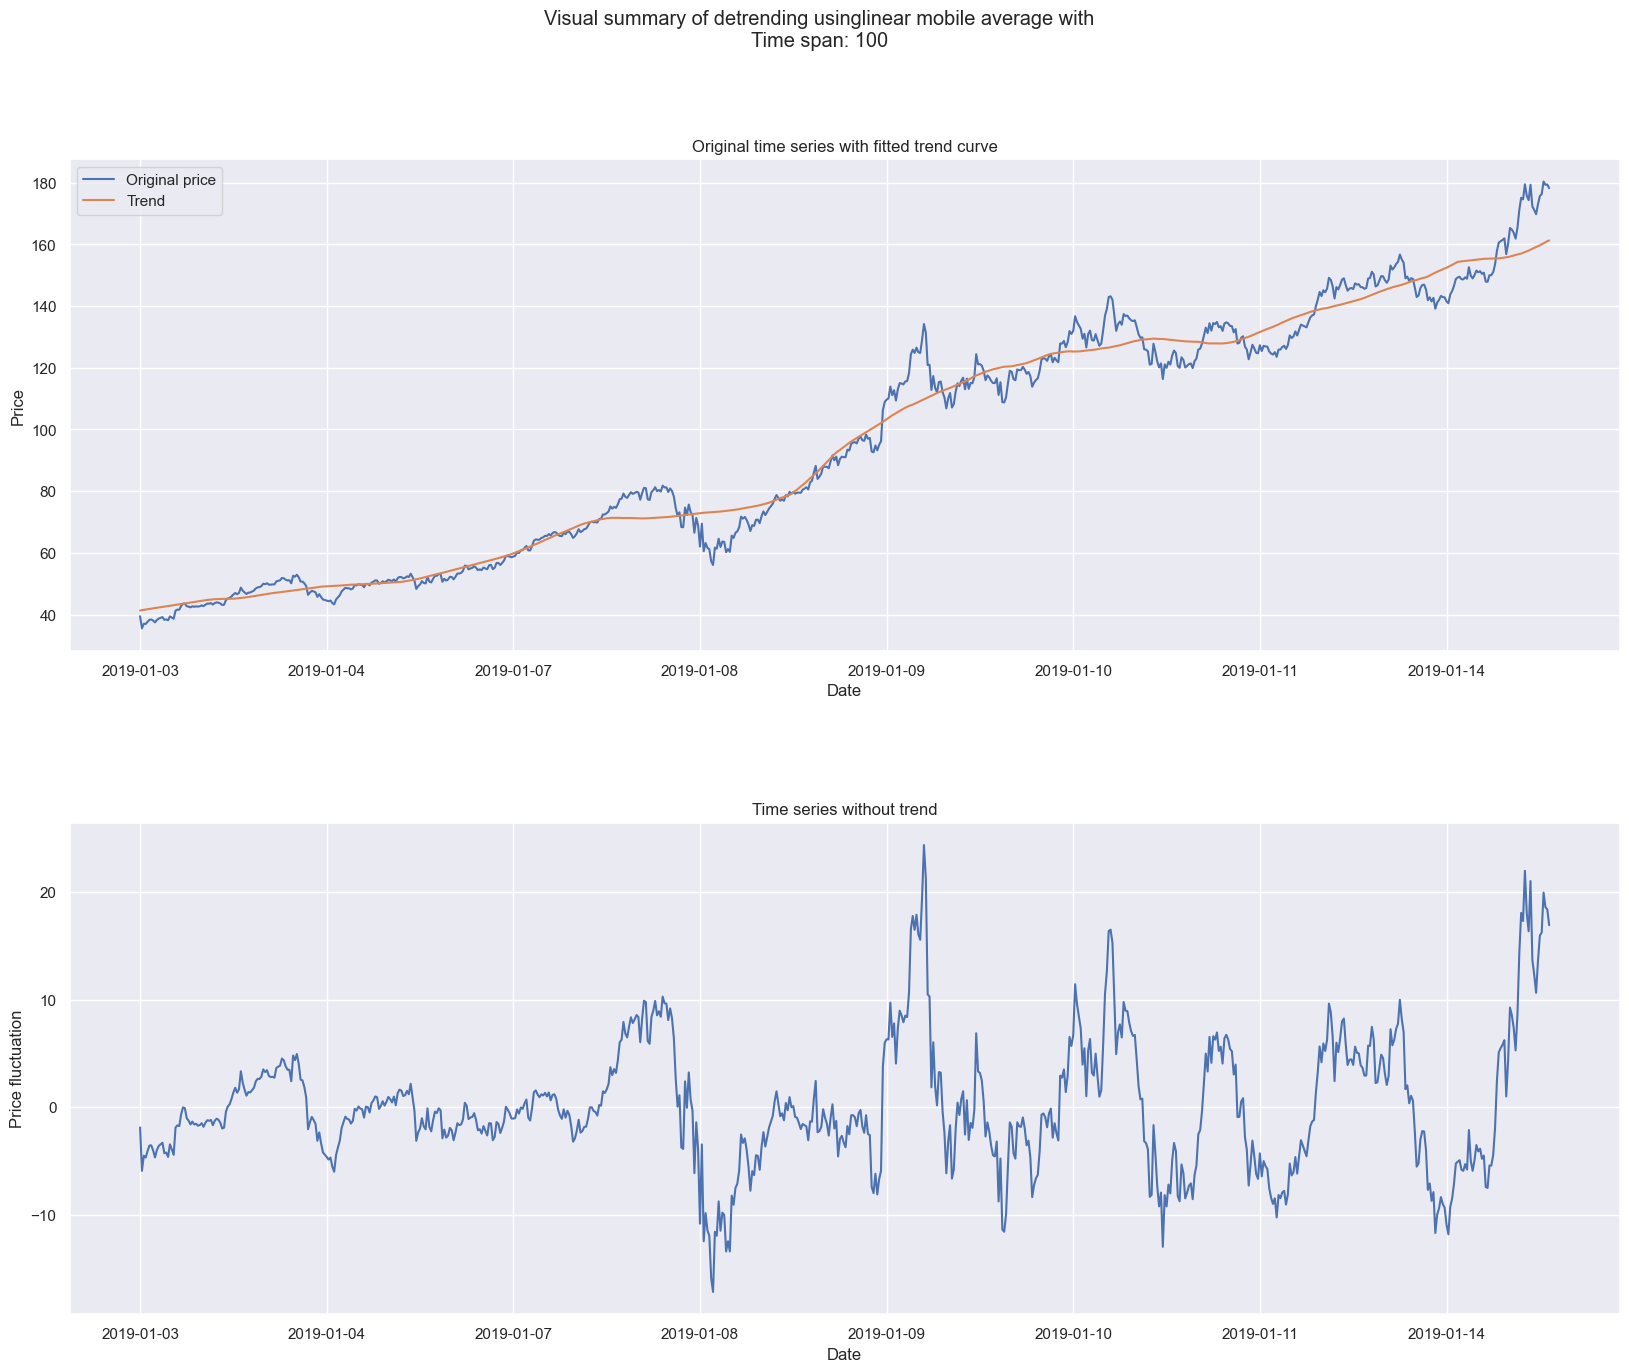

In [ ]:
# Define detrend model
detrend_model = LinearMADetrend(window=100)

# Fit model to time series
y_fitted = detrend_model.fit(y)

# Substract adjusted values to original time series to get detrend data
y_detrend = detrend_model.predict(y)

# Plot the result
detrend_model.fancy_plot(xticklabels=df.index.strftime("%Y-%m-%d"))

In [ ]:
aic_detrend = aic(y, y_detrend, 2)
mse_detrend = mean_squared_error(y, y_detrend)
detrend_dict["Moyenne mobile linéaire"] = [aic_detrend, mse_detrend]

#### Exponentielle

La moyenne mobile exponentielle fait partie de la famille des moyennes mobiles pondérées.

On se munit de $(x_t)_{t \in \mathbb{N}}$ une série temporelle.  

Soit $t \in \mathbb{N}^*$ et $\alpha \in [0;1]$ une constante de lissage.

$$
\begin{align}
expma(x_{t})
    & = \alpha \left ( x_t + (1 - \alpha) x_{t - 1} + (1 - \alpha)^2 x_{t-2} + (1 - \alpha)^3 x_{t - 3} + \dots \right ) \\
    & = \displaystyle\sum_{n = 0}^{t} \alpha(1 - \alpha)^n x_{t - n}
\end{align}
$$

On remarque que la moyenne mobile exponentielle à l'instant $t$ prend en compte toutes les données qui précèdent. Toutefois, les valeurs très antérieures impactent très peu le résultat - d'autant plus que $\alpha$ est grand - et peuvent donc être négligées.

C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\src\functions\detrend_fancy_plot.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(xticklabels)
C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\src\functions\detrend_fancy_plot.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(xticklabels)


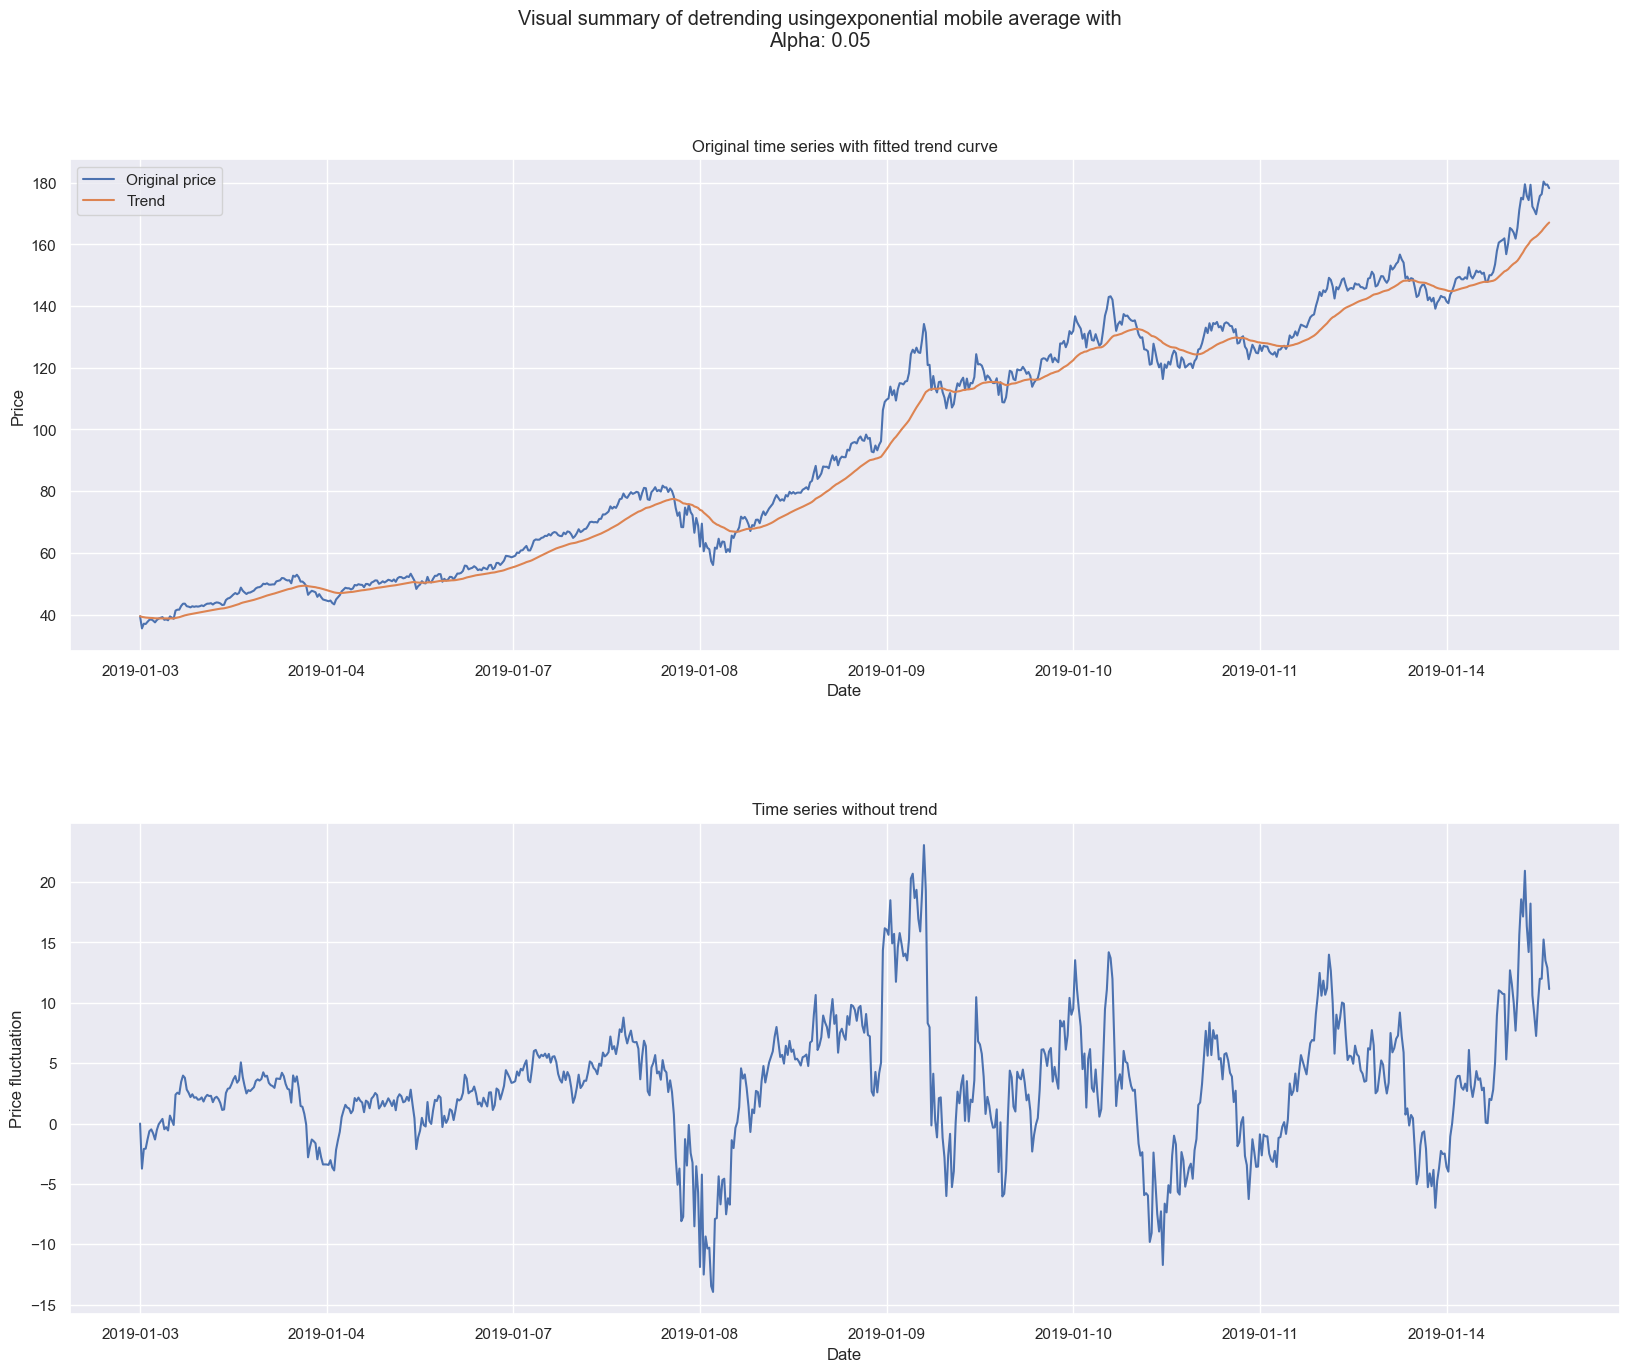

In [ ]:
# Define detrend model
detrend_model = ExponentialMADetrend(alpha=0.05)

# Fit model to time series
y_fitted = detrend_model.fit(y)

# Substract adjusted values to original time series to get detrend data
y_detrend = detrend_model.predict(y)

# Plot the result
detrend_model.fancy_plot(xticklabels=df.index.strftime("%Y-%m-%d"))

In [ ]:
aic_detrend = aic(y, y_detrend, 2)
mse_detrend = mean_squared_error(y, y_detrend)
detrend_dict["Moyenne mobile exponentielle"] = [aic_detrend, mse_detrend]

### B-splines

Étant donné $m + 1$ nœuds $ \{t_i \in [0, 1]\}_{i \in [0, m]} $ indexés selon le temps,  
une courbe spline de degré $n \in \mathbb{N^*}$ est une fonction paramétrique définie par :  

$$ \mathbf{S} \,:\, [0,1] \to \mathbb{R}^d$$

$$
S : \begin{cases}
\mathbb{[0, 1]} & \rightarrow \mathbb{R}^2 \\
t & \rightarrow \displaystyle \sum_{i = 0}^{m - n - 1} b_{i, n} (t) . \mathbf{P}_{i} * \mathbb{1}_{t \in [t_{n}, t_{m-n}]}
\end{cases}
$$


Les B-splines sont des fonctions utilisées pour l'interpolation ou l'approximation de fonctions continues à partir de données discrètes.  

$\forall k \in \mathbb{N^*}$, la fonction B-spline de degré k, notée $B_{i, k}(t)$, est définie récursivement comme suit :

$$ B_{i,0}(t) = \begin{cases} 1 & \text{si } t_i \leq t < t_{i+1} \\ 0 & \text{sinon} \end{cases} $$


$$
B_{i,k}(t) = \frac{t - t_i}{t_{i+k} - t_i} B_{i,k-1}(t) + \frac{t_{i+k+1} - t}{t_{i+k+1} - t_{i+1}} B_{i+1,k-1}(t)
$$

Pour $ i \in {0,1,…,n−k−2}$, où $n$ est le nombre total de points de contrôle et $k$ est l'ordre des B-splines.

In [ ]:
# Define parameters for B-splines

interval_length = 50  # Days between two knots
degree = 3

C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\src\functions\detrend_fancy_plot.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(xticklabels)
C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\src\functions\detrend_fancy_plot.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(xticklabels)


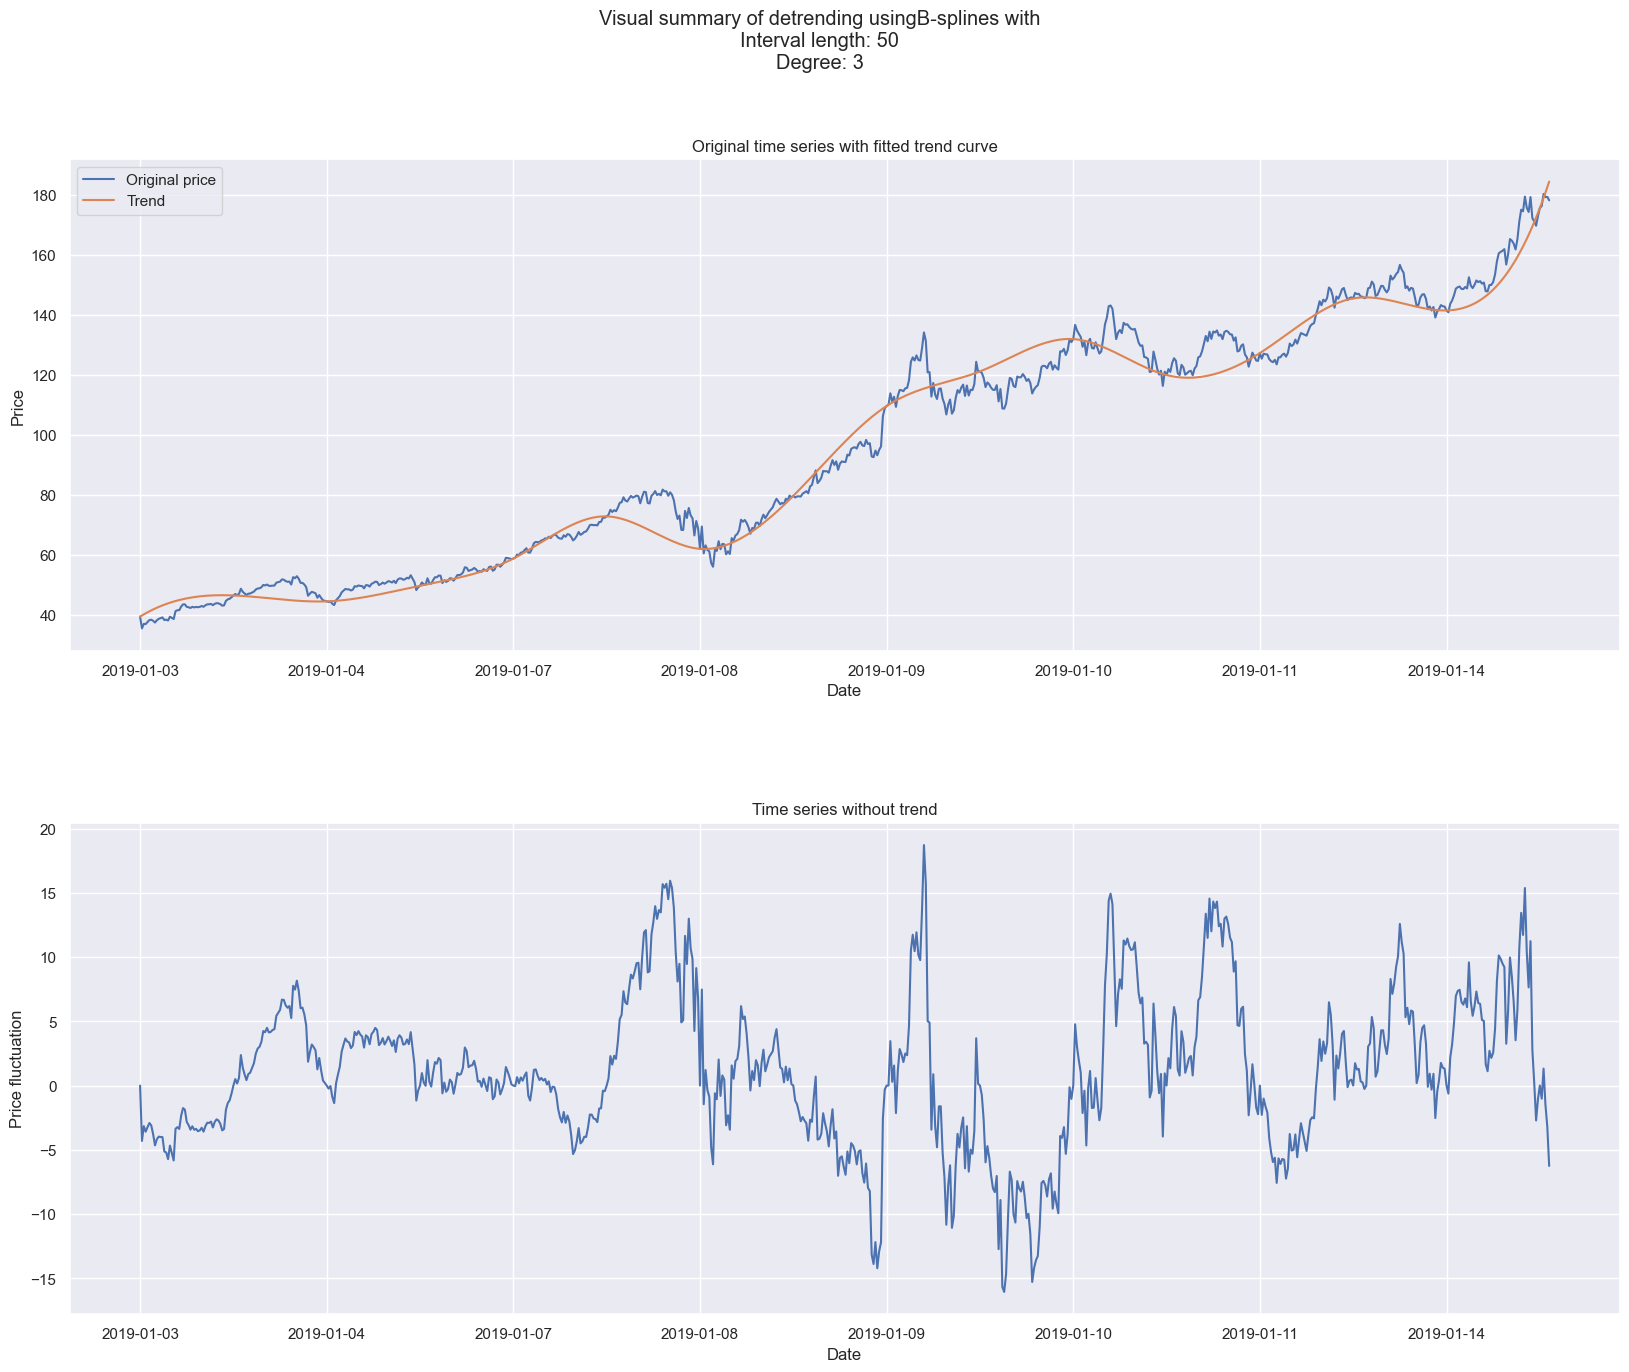

In [ ]:
# Define detrend model
detrend_model = BSplinesDetrend(interval_length=interval_length, degree=degree)

# Fit model to time series
y_fitted = detrend_model.fit(y)

# Substract adjusted values to original time series to get detrend data
y_detrend = detrend_model.predict(y)

# Plot the result
detrend_model.fancy_plot(xticklabels=df.index.strftime("%Y-%m-%d"))

In [ ]:
aic_detrend = aic(y, y_detrend, 2)
mse_detrend = mean_squared_error(y, y_detrend)
detrend_dict["B-Splines"] = [aic_detrend, mse_detrend]

La méthode des BSplines de degré 1 correspond à de l'interpolation linéaire :

In [ ]:
detrend_df = pd.DataFrame(detrend_dict).T
detrend_df.columns = ["AIC", "MSE"]
detrend_df["Graphiquement"] = "✅"

In [ ]:
# print(detrend_df.to_markdown())

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Régression linéaire'),
  Text(1, 0, 'Régression polynomiale'),
  Text(2, 0, 'Moyenne mobile linéaire'),
  Text(3, 0, 'Moyenne mobile exponentielle'),
  Text(4, 0, 'B-Splines')])

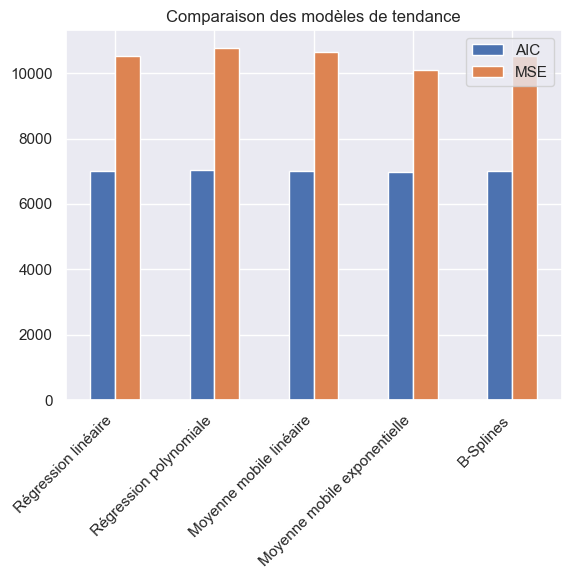

In [ ]:
detrend_df[["AIC", "MSE"]].plot(kind="bar")
plt.title("Comparaison des modèles de tendance")

plt.xticks(rotation=45, ha="right")

**Tableau.** Comparaison des modèles de tendance

|                                  |         AIC |         MSE | Graphiquement |
|:---------------------------------|------------:|------------:|:--------------|
| Régression linéaire              |     7005.56 |     10523.1 | ✅             |
| Régression polynomiale           |     7023.09 |       10770 | ✅             |
| Moyenne mobile linéaire          |     7014.76 |     10651.8 | ✅             |
| **Moyenne mobile exponentielle** | **6973.26** | **10082.9** | ✅             |
| B-Splines                        |     7005.56 |     10523.1 | ✅             |

Meilleur modèle : moyenne mobile exponentielle